In [216]:
import os
import sys
import csv
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision import transforms
from skimage import io
from PIL import Image

In [217]:
df = pd.read_csv("./mask_class_8.csv")

In [218]:
df.head(10)

,Unnamed: 0,file,class
0,2919,001038_male_Asian_60/incorrect_mask.jpg,8.0
1,2961,001043_male_Asian_60/incorrect_mask.jpg,8.0
2,2996,001047_male_Asian_60/incorrect_mask.jpg,8.0
3,3332,001101_male_Asian_60/incorrect_mask.jpg,8.0
4,3654,001152_male_Asian_60/incorrect_mask.jpg,8.0
5,3801,001175_male_Asian_60/incorrect_mask.jpg,8.0
6,3920,001188_male_Asian_60/incorrect_mask.jpg,8.0
7,5005,001444_male_Asian_60/incorrect_mask.jpg,8.0
8,5124,001464_male_Asian_60/incorrect_mask.jpg,8.0
9,5306,001494_male_Asian_60/incorrect_mask.jpg,8.0


In [235]:
len(df)

83

In [219]:
class MaskAugmentationDataset(Dataset):
    def __init__(self, transform, annotations_1, annotations_2, root_dir):
        self.transform = transform
        self.annotations_1 = annotations_1
        self.annotations_2 = annotations_2
        self.root_dir = root_dir
        
    
    def __len__(self):
        return len(self.annotations_1)
    
    def __getitem__(self, idx):
        # 첫 번째 이미지 클래스
        img_path_1 = os.path.join(self.root_dir, self.annotations_1.loc[idx, 'file'])
        
        # 두 번째 이미지 클래스
        img_path_2 = os.path.join(self.root_dir, self.annotations_2.loc[idx, 'file'])
        
        # Load an image from file -> ndarray
        image_1 = io.imread(img_path_1)
        image_2 = io.imread(img_path_2)
        label_1 = torch.tensor(int(self.annotations_1.loc[idx, 'class']))
        label_2 = torch.tensor(int(self.annotations_2.loc[idx, 'class']))

        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)
        return [(image_1, label_1), (image_2, label_2)]

In [220]:
# |input size| = batch, channel, h, w
# lam = beta-dist를 따르는 랜덤값
def rand_bbox(size, lam):
    H = size[2]
    W = size[3]
    cut_rat = np.sqrt(1. - lam)
    
    # 패치의 가로, 세로
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치의 꼭짓점 4개
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [228]:
def Cutmix(num1, num2):
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor()])

    annotations_1 = pd.read_csv(".//mask_class_"+str(num1)+".csv")
    annotations_2 = pd.read_csv(".//.//mask_class_"+str(num2)+".csv")
    root_dir = ".//images//images//"
    lam = np.random.beta(1.0, 1.0)
    
    custom_dataset = MaskAugmentationDataset(transform, annotations_1, annotations_2, root_dir)

    # 83은 각 클래스의 이미지 갯수가 83개여서...나중에 수정필요
    for (img_1, label_1), (img_2, label_2) in DataLoader(custom_dataset, batch_size=83):
        
        img_size = img_1.size()
        p_x_1, p_y_1, p_x_2, p_y_2 = rand_bbox(img_size, lam)
        
        # 이미지를 섞는다
        rand_index = torch.randperm(img_size[0])
        
        
        
        img_p = img.clone()
        
        # 각 클래스의 이미지에 다른 클래스 이미지 패치
        img_2[:,:,p_y_1:p_y_2, p_x_1:p_x_2], img_1[:,:,p_y_1:p_y_2, p_x_1:p_x_2] =  img_1[rand_index,:, p_y_1:p_y_2, p_x_1:p_x_2], img_2[rand_index,:, p_y_1:p_y_2, p_x_1:p_x_2]
        
        # 이미지 주피터로 찍어보고 싶을 때
        # im_pil = transforms.ToPILImage()(img_1[0])
        # return im_pil
        #break
        
        # 이미지 파일 저장
        for i in range(img_size[0]):
            save_image(img_1[i, :, :, :], './/cutmix_class_'+str(num1)+'_'+str(num2)+'//img_'+str(num1)+'_'+str(i)+'.png')
            save_image(img_2[i, :, :, :], './/cutmix_class_'+str(num1)+'_'+str(num2)+'//img_'+str(num2)+'_'+str(i)+'.png')
            
            # 두 클래스의 이미지 파일 경로와 라벨값을 csv파일로 저장
            with open('cutmix_class_'+str(num1)+'_'+str(num2)+'.csv','a') as f:
                wr = csv.writer(f)
                wr.writerow(['cutmix_class_'+str(num1)+'_'+str(num2)+'_normal//img_'+str(num1)+'_'+str(i)+'.png', lam*label_1[i].item() + (1-lam) * label_2[i].item()])
            with open('cutmix_class_'+str(num2)+'_'+str(num1)+'.csv','a') as z:
                wr = csv.writer(z)
                wr.writerow(['cutmix_class_'+str(num2)+'_'+str(num1)+'_normal//img_'+str(num2)+'_'+str(i)+'.png', lam*label_2[i].item() + (1-lam) * label_1[i].item()])

In [229]:
# 8번 클래스와 14번 클래스의 이미지들을 Cutmix 실행
Cutmix(8, 14)

### 생각
1. 일단 각 클래스별 이미지 갯수가 어느 정도 비슷해야 한다 -> drop_last쓰면 되지만 너무 안맞으면 augmentation 많이 안될 것 같다
2. 이미지를 얼굴만 잘 확대되도록 전처리 하면 좋을 것 같다 -> 어떤 사람들은 처음부터 얼굴 빡 사진이고 어떤 사람들은 증명사진이라 단순히 centor crop으로 안될 것 같다
3. 얼굴 근처에서 cutmix 많이 되도록 cutmix 위치를 uniform이 아니라 다른 distribution쓰면 더 좋을 것 같다

#### 패치 위치를 이미지의 중앙에서 정규분포를 따르는 랜덤 변수로 변경

In [203]:
def rand_bbox_normal(size, lam, sigma):
    H = size[2]
    W = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = sigma*np.random.randn() + W//2
    cy = sigma*np.random.randn() + H//2

    bbx1 = np.clip(cx - cut_w // 2, 0, W//2)
    bby1 = np.clip(cy - cut_h // 2, 0, H//2)
    bbx2 = np.clip(cx + cut_w // 2, 0, W//2)
    bby2 = np.clip(cy + cut_h // 2, 0, H//2)

    return int(bbx1), int(bby1), int(bbx2), int(bby2)

In [236]:
# 중앙을 중심으로 지킬앤 하이드 처럼 좌우에 컷믹스
def rand_bbox_normal_left_right(size, lam, sigma):
    H = size[2]
    W = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = sigma*np.random.randn() + W//2
    cy = sigma*np.random.randn() + H//2

    bbx1 = np.clip(cx - cut_w // 2, 0, W//2)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W//2)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return int(bbx1), int(bby1), int(bbx2), int(bby2)

In [237]:
# 위아래 컷믹스
def rand_bbox_normal_up_down(size, lam, sigma):
    H = size[2]
    W = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = sigma*np.random.randn() + W//2
    cy = sigma*np.random.randn() + H//2

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H//2)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H//2)

    return int(bbx1), int(bby1), int(bbx2), int(bby2)

In [238]:
# 위의 Cutmix 클래스랑 동일, 이미지 파일 저장되는 이름만 left-right 또는 up-down.png 이런식으로 하려고
def Cutmix_normal(num1, num2, sigma):
    transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor()])

    annotations_1 = pd.read_csv(".//mask_class_"+str(num1)+".csv")
    annotations_2 = pd.read_csv(".//.//mask_class_"+str(num2)+".csv")
    root_dir = ".//images//images//"

    custom_dataset = MaskAugmentationDataset(transform, annotations_1, annotations_2, root_dir)
    lam = np.random.beta(1.0, 1.0)
    for (img_1, label_1), (img_2, label_2) in DataLoader(custom_dataset, batch_size=83):
        img_size = img_1.size()
        
        p_x_1, p_y_1, p_x_2, p_y_2 = rand_bbox_normal_left_right(img_size, lam, sigma)
        rand_index = torch.randperm(img_size[0])
        img_p = img.clone()
        img_2[:,:,p_y_1:p_y_2, p_x_1:p_x_2], img_1[:,:,p_y_1:p_y_2, p_x_1:p_x_2] =  img_1[rand_index,:, p_y_1:p_y_2, p_x_1:p_x_2], img_2[rand_index,:, p_y_1:p_y_2, p_x_1:p_x_2]
        
        im_pil = transforms.ToPILImage()(img_1[0])
        return im_pil
        break
#         for i in range(img_size[0]):
#             save_image(img_1[i, :, :, :], './/cutmix_class_'+str(num1)+'_'+str(num2)+'_normal//img_'+str(num1)+'_'+str(i)+'left_right.png')
#             save_image(img_2[i, :, :, :], './/cutmix_class_'+str(num1)+'_'+str(num2)+'_normal//img_'+str(num2)+'_'+str(i)+'left_right.png')
#             with open('cutmix_class_'+str(num1)+'_'+str(num2)+'_normal_left_right.csv','a') as f:
#                 wr = csv.writer(f)
#                 wr.writerow(['cutmix_class_'+str(num1)+'_'+str(num2)+'_normal//img_'+str(num1)+'_'+str(i)+'left_right.png', lam*label_1[i].item() + (1-lam) * label_2[i].item()])
#             with open('cutmix_class_'+str(num2)+'_'+str(num1)+'_normal_left_right.csv','a') as z:
#                 wr = csv.writer(z)
#                 wr.writerow(['cutmix_class_'+str(num2)+'_'+str(num1)+'_normal//img_'+str(num2)+'_'+str(i)+'left_right.png', lam*label_2[i].item() + (1-lam) * label_1[i].item()])
                
 


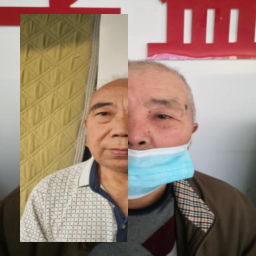

In [187]:
Cutmix_normal(8, 14, 3)